In [47]:
import re
import requests
import shutil 
import os
import io
import wget
import selenium
import base64
import lxml
import dill
import pandas as pd
import gzip
import numpy as np

from collections import Counter
from matplotlib import image
from urllib.request import urlretrieve 
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
from IPython.display import Image
from selenium import webdriver 
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By 
from selenium.webdriver.common.keys import Keys
from chromedriver_py import binary_path
from pathlib import Path 
from shutil import copyfileobj
from itertools import chain
from time import sleep
from urllib.error import HTTPError

In [48]:
pd.set_option('display.max_colwidth', None)

In [49]:
browser=webdriver.Chrome(executable_path=binary_path)

In [50]:
IMG_SIZE=(224,)
LABELS={ 
#zillow
"disrepair kitchen site:zillow.com":0,
"old broken kitchen site:Redfin.com":0,
"dilapidated kitchen site:zillow.com":0,
"dirty kitchen site:zillow.com":0,
"abandoned dirty kitchen site:zillow.com":0,
"small messy kitchen site:zillow.com":0,

"cheap condo kitchen site:zillow.com":1,
"cheap apartment kitchen site:zillow.com":1,
"motel kitchen site:zillow.com":1,

"luxurious kitchen site:zillow.com":2,
"expensive kitchen site:zillow.com":2,
"mansion kitchen site:zillow.com":2,
}
N_CLASSES=3
MAIN_DUMPATH= "./capstonedump"
PHOTO_DUMPATH="./capstonedump/photos"
LINK_DUMPATH="./capstonedump/links"
DEMO_LISTINGS_DUMPATH=f"{MAIN_DUMPATH}/demo-listings"

#### notes

```python
LABELS={ 
#zillow
"disrepair kitchen site:zillow.com":0,
"old broken kitchen site:Redfin.com":0,
"dilapidated kitchen site:zillow.com":0,
"dirty kitchen site:zillow.com":0,
"abandoned dirty kitchen site:zillow.com":0,
"small messy kitchen site:zillow.com":0,

"cheap condo kitchen site:zillow.com":1,
"cheap apartment kitchen site:zillow.com":1,
"motel kitchen site:zillow.com":1,

"luxurious kitchen site:zillow.com":2,
"expensive kitchen site:zillow.com":2,
"mansion kitchen site:zillow.com":2,
    
#redfin
"disrepair kitchen site:Redfin.com":0,
"old broken kitchen site:Redfin.com":0,
"dilapidated kitchen site:Redfin.com":0,
"dirty kitchen site:Redfin.com":0,
"abandoned dirty kitchen site:Redfin.com":0,

"cheap condo kitchen site:Redfin.com":1,
"cheap apartment kitchen site:Redfin.com":1,
"motel kitchen site:Redfin.com":1,

"luxurious kitchen site:Redfin.com":2,
"expensive kitchen site:Redfin.com":2,
"mansion kitchen site:Redfin.com":2,
  
#Realtor    
"disrepair kitchen site:Realtor.com":0,
"old broken kitchen site:Realtor.com":0,
"dilapidated kitchen site:Realtor.com":0,
"dirty kitchen site:Realtor.com":0,

"cheap condo kitchen site:Realtor.com":1,
"cheap apartment kitchen site:Realtor.com":1,
"motel kitchen site:Realtor.com":1,

"luxurious kitchen site:Realtor.com":2,
"expensive kitchen site:Realtor.com":2,
"mansion kitchen site:Realtor.com":2,
    
#Trulia
"disrepair kitchen site:Trulia.com":0,
"old broken kitchen site:Trulia.com":0,
"dilapidated kitchen site:Trulia.com":0,
"dirty kitchen site:Trulia.com":0,

"cheap condo kitchen site:Trulia.com":1,
"cheap apartment kitchen site:Trulia.com":1,
"motel kitchen site:Trulia.com":1,

"luxurious kitchen site:Trulia.com":2,
"expensive kitchen site:Trulia.com":2,
"mansion kitchen site:Trulia.com":2,

#homefinder
"disrepair kitchen site:HomeFinder.com":0,
"old broken kitchen site:HomeFinder.com":0,
"dilapidated kitchen site:HomeFinder.com":0,
"dirty kitchen site:HomeFinder.com":0,

"cheap condo kitchen site:HomeFinder.com":1,
"cheap apartment kitchen site:HomeFinder.com":1,
"motel kitchen site:HomeFinder.com":1,

"luxurious kitchen site:HomeFinder.com":2,
"expensive kitchen site:HomeFinder.com":2,
"mansion kitchen site:HomeFinder.com":2
}
```

## older stuffs

```python
urls=["https://www.redfin.com/VA/Annandale/3428-Holly-Rd-22003/home/9626608",
      "https://ssl.cdn-redfin.com/photo/235/bigphoto/914/VAFX2004914_22_1.jpg",
      "https://photos.zillowstatic.com/fp/0954eb5046a8118ddc8b29a1ac3196b3-uncropped_scaled_within_1536_1152.webp",
      "https://www.zillow.com/homedetails/333-Haight-St-3-San-Francisco-CA-94102/2069806984_zpid/?mmlb=g,24", 
      "https://www.zillow.com/san-francisco-ca/",
      "https://duckduckgo.com/?q=&iar=images"
     ] 
```

```python
save_path="./capstone_imgs/untitled.jpg"
urllib.request.urlretrieve(urls[1], save_path)
```

```python
def download_img(url, file_name, save_dir="./capstone_imgs/", extension=".jpg"): 
    save_path=save_dir+file_name+extension
    urllib.request.urlretrieve(url, save_path)
    return save_path
Image(filename=download_img(urls[2], "untitled", ""), width=300)
```

```python 
url_sf_search=urls[4]
headers={
    'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'cookie': 'zguid=23|%249897bb73-322e-443d-9c65-b059de49645e; zgsession=1|e9d13b80-9e85-4ee2-a265-befaa1015074; _ga=GA1.2.354669291.1626721515; _gid=GA1.2.548584873.1626721515; zjs_user_id=null; _pxvid=4138eae9-e8c4-11eb-a486-0242ac120007; _gcl_au=1.1.2033665599.1626721520; KruxPixel=true; DoubleClickSession=true; __pdst=3831350651364e4088d2a56dc79d4c32; _fbp=fb.1.1626721520475.1379154349; _pin_unauth=dWlkPU1XUTRaamt4TkRZdE9HUTJNaTAwTWpRM0xUazNORFF0TTJJNU1qQm1ZMlEyWkRJMQ; KruxAddition=true; _gac_UA-21174015-56=1.1626728921.Cj0KCQjwxdSHBhCdARIsAG6zhlWl1Aadyg0WwouP1bhO1ORDi8KRryrsrR6HXWjMFQFWECffcWRT64kaApsLEALw_wcB; zjs_utmcontent=%221471764169|65545421228|aud-352785740844:kwd-570802407|509015461848|%22; _gcl_aw=GCL.1626728922.Cj0KCQjwxdSHBhCdARIsAG6zhlWl1Aadyg0WwouP1bhO1ORDi8KRryrsrR6HXWjMFQFWECffcWRT64kaApsLEALw_wcB; JSESSIONID=E93CFF85480FE8A19763F0035F16168C; search=6|1629321958191%7Cregion%3Dsan-francisco-ca%26rect%3D38.76%252C-121.48%252C36.76%252C-123.48%26disp%3Dmap%26mdm%3Dauto%26pt%3Dpmf%252Cpf%26fs%3D1%26fr%3D0%26mmm%3D1%26rs%3D0%26ah%3D0%09%0920330%09%09%09%09%09%09; _gat=1; optimizelyEndUserId=oeu1626730194420r0.5311478475437017; zjs_anonymous_id=%229897bb73322e443d9c65b059de49645e%22; _pxff_bsco=1; _pxff_tm=1; _cs_mk=0.6538874072009262_1626730195754; _uetsid=42ee8700e8c411ebbb3725192d4851da; _uetvid=42ef55d0e8c411eba5df59405c258be5; _cs_c=1; _hp2_id.1215457233=%7B%22userId%22%3A%223048392848713395%22%2C%22pageviewId%22%3A%222797487669787189%22%2C%22sessionId%22%3A%22185358963487907%22%2C%22identity%22%3Anull%2C%22trackerVersion%22%3A%224.0%22%7D; _hp2_ses_props.1215457233=%7B%22r%22%3A%22https%3A%2F%2Fwww.zillow.com%2Fsan-francisco-ca%2F%3FsearchQueryState%3D%257B%2522usersSearchTerm%2522%253A%2522san%2520francisco%252C%2520CA%2522%252C%2522mapBounds%2522%253A%257B%2522west%2522%253A-122.75399245214844%252C%2522east%2522%253A-122.28020705175781%252C%2522south%2522%253A37.53038405238991%252C%2522north%2522%253A37.90299568470347%257D%252C%2522mapZoom%2522%253A11%252C%2522regionSelection%2522%253A%255B%257B%2522regionId%2522%253A20330%252C%2522regionType%2522%253A6%257D%255D%252C%2522isMapVisible%2522%253Afalse%252C%2522filterState%2522%253A%257B%2522ah%2522%253A%257B%2522value%2522%253Atrue%257D%252C%2522sort%2522%253A%257B%2522value%2522%253A%2522globalrelevanceex%2522%257D%257D%252C%2522isListVisible%2522%253Atrue%252C%2522category%2522%253A%2522cat1%2522%257D%22%2C%22ts%22%3A1626730196114%2C%22d%22%3A%22www.zillow.com%22%2C%22h%22%3A%22%2Fz%2Fcorp%2Fterms%2F%22%7D; utag_main=v_id:017ac0288ab8000fac6a960cca9d03079002d07100942$_sn:2$_se:1$_ss:1$_st:1626731995917$dc_visit:2$ses_id:1626730195917%3Bexp-session$_pn:1%3Bexp-session$dcsyncran:1%3Bexp-session$tdsyncran:1%3Bexp-session$dc_event:1%3Bexp-session; _px3=9cd39b2b24d143820cc14c813661abad9d222a289d995cd7cee47ae66b361bf1:7l+G2U6wIlf5RWoVsNjWh76ovZ6a+i/PTxq63XtJUB4288ZPohcdD1M7Jxreeu6PWHKk2RwxOu/bTIPnMOkAxA==:1000:/JFnD71W7z1MkByqHUTiDWu37i8FWkUzXT4nYqC0eaIEUklm67DCWY8Rk288HCXZNPISWTSGDVIs6X2hRhHMXuyMsCgQ97GQzgIrZqoemu6p87rV3k47qXmzdSxYlisvSlaY/kARYTLJSUSIwTuZaAF9gIxmps7suUfbdMN4hTL1h6L3zE0DtOykQU+CBSXtfQnKLNCHfxX43fZqF1nZQA==; _cs_id=4b3370e1-1f39-a927-8eb8-cb6d65dcd9ce.1626730196.1.1626730196.1626730196.1.1660894196797.Lax.0; _cs_s=1.1.0.1626731996801; __CT_Data=gpv=1&ckp=tld&dm=zillow.com&apv_82_www33=1&cpv_82_www33=1; AWSALB=nTnBKOWzdIo5upfl8Qf8GDB9014cA5Xy0D3+pQFNTYatXJEQcCYIElhzhD3ykI6mbtARuzCRrYnb99iyjXH6LzHFnXIaLfeQSHGR4ItSYyE0/W7U7rH3TUaSZeht; AWSALBCORS=nTnBKOWzdIo5upfl8Qf8GDB9014cA5Xy0D3+pQFNTYatXJEQcCYIElhzhD3ykI6mbtARuzCRrYnb99iyjXH6LzHFnXIaLfeQSHGR4ItSYyE0/W7U7rH3TUaSZeht; OptanonAlertBoxClosed=2021-07-19T21:29:59.295Z; OptanonConsent=isIABGlobal=false&datestamp=Mon+Jul+19+2021+14%3A29%3A59+GMT-0700+(Pacific+Daylight+Time)&version=5.11.0&landingPath=NotLandingPage&groups=1%3A1%2C3%3A1%2C4%3A1&consentId=f93c1241-2819-4c86-8491-0515afb55b7c',    
    'referer': 'https://www.zillow.com/san-francisco-ca/?searchQueryState=%7B%22pagination%22%3A%7B%7D%2C%22usersSearchTerm%22%3A%22san%20francisco%2C%20CA%22%2C%22mapBounds%22%3A%7B%22west%22%3A-122.75399245214844%2C%22east%22%3A-122.28020705175781%2C%22south%22%3A37.53038405238991%2C%22north%22%3A37.90299568470347%7D%2C%22regionSelection%22%3A%5B%7B%22regionId%22%3A20330%2C%22regionType%22%3A6%7D%5D%2C%22isMapVisible%22%3Atrue%2C%22filterState%22%3A%7B%22sort%22%3A%7B%22value%22%3A%22globalrelevanceex%22%7D%2C%22ah%22%3A%7B%22value%22%3Atrue%7D%7D%2C%22isListVisible%22%3Atrue%2C%22mapZoom%22%3A11%7D',
    'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
    'sec-ch-ua-mobile': '?0',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mo'
}
params={"usersSearchTerm":"san francisco, CA",
        "mapBounds":{"west":-122.75399245214844,
                     "east":-122.28020705175781,
                     "south":37.53038405238991,
                     "north":37.90299568470347},
        "mapZoom":11,"regionSelection":[{"regionId":20330,"regionType":6}],
        "isMapVisible":'false',
        "filterState":{"ah":{"value":'true'},"sort":{"value":"globalrelevanceex"}},
        "isListVisible":'true',"category":"cat1"}
response=requests.get(url_sf_search, headers=headers, params=params)
response
```

```python 
%%time
content=BeautifulSoup(response.text)
deck=content.find('ul', {'class':"photo-cards photo-cards_wow photo-cards_short photo-cards_extra-attribution"})
deck.find_all('a', {'class': 'list-card-link list-card-link-top-margin list-card-img'})
thumbnails=deck.find_all('img')
[download_img(X['src'], f"thumbnail#{i}") for i, X in enumerate(thumbnails)]
```

`Image(filename='./capstone_imgs/thumbnail#0.jpg')`

`url_bathroom_search=urls[5] `

```python 
%%time
url_bathroom_search="https://duckduckgo.com/?q={}&t=h_&iax=images&ia=images".format('bathroompictures')
headers={
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    'referer': 'https://duckduckgo.com/',
    'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
    'sec-ch-ua-mobile': '?0',
    'sec-fetch-dest': 'document','sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin','sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
}
params={
    'q': 'bathroom pictures',
    'va': 'b',
    't': 'hc',
    'iax': 'images',
    'ia': 'images'
}
response=requests.get(url_bathroom_search,headers=headers)
response
```

```python 
content=BeautifulSoup(response.text, 'html.parser') 
# deck=content.find('div',{'class':'zci__main  zci__main--tiles  js-tiles   has-nav tileview__images has-tiles--grid'})
# deck.find_all('div', {'class':'tile  tile--img  has-detail'})
# print(deck)
print(content.prettify())
```

```python 
# url_google_search="https://www.google.com/search?q=bathroom&picturestbm=isch&ved=2ahUKEwiPkIuSivHxAhWeATQIHRX7Dc4Q2-cCegQIABAA&oq=bathroom+pictures&gs_lcp=CgNpbWcQAzIFCAAQsQMyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADICCABQ-QFY-QFgyQNoAHAAeACAAY0BiAGNAZIBAzAuMZgBAKABAaoBC2d3cy13aXotaW1nwAEB&sclient=img&ei=93T2YM-4E56D0PEPlfa38Aw&bih=798&biw=1440&hl=en"
url_google_search="https://www.google.com/search?site=&tbm=isch&source=hp&biw=1873&bih=990&q=" + 'bathroom+pictures'
headers={
'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
'accept-encoding': 'gzip, deflate, br',
'accept-language': 'en-US,en;q=0.9',
'cache-control': 'max-age=0',
'cookie': 'CGIC=IocBdGV4dC9odG1sLGFwcGxpY2F0aW9uL3hodG1sK3htbCxhcHBsaWNhdGlvbi94bWw7cT0wLjksaW1hZ2UvYXZpZixpbWFnZS93ZWJwLGltYWdlL2FwbmcsKi8qO3E9MC44LGFwcGxpY2F0aW9uL3NpZ25lZC1leGNoYW5nZTt2PWIzO3E9MC45; OTZ=6074342_84_88_104280_84_446940; NID=219=3iI2G9KOUu0UeWJwufF5yp7e_YWy-Jqa4sy6AQBq9A83KkTQi60R5DLh4WIjX5DdL-ySYAthc4Q58RcCsUFFfAESvW5PpbrVaBapJsgu_UguDnOPTFVXCd5zQxj0cPekrFR4UigyfIVR2-xAFjdZA376dkAsnrTvx9AJsJ5vZJE; OGPC=19022591-1:; DV=w-MBoejvLyEj4OgbEydFW6gZm-YrrJeKpsw9cz05QgEAAAA; 1P_JAR=2021-7-20-7',
'referer': 'https://www.google.com/',
'sec-ch-ua': '" Not;A Brand";v="99", "Google Chrome";v="91", "Chromium";v="91"',
'sec-ch-ua-mobile': '?0',
'sec-fetch-dest': 'document',
'sec-fetch-mode': 'navigate',
'sec-fetch-site': 'same-origin',
'sec-fetch-user': '?1',
'upgrade-insecure-requests': '1',
'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
}
params={
'q': 'bathroom pictures',
'hl': 'en',
'tbm': 'isch',
'source': 'lnms',
'sa': 'X',
'ved': '0ahUKEwinpbC-i_HxAhXPrJ4KHU5CAGkQ_AUI1gcoAQ',
'biw': '1440',
'bih': '798'
}
res=requests.get(url_google_search, headers=headers, params=params)
res
```

```python
content=BeautifulSoup(res.text, 'html.parser') 
deck=content.find_all('img', {'class':'rg_i Q4LuWd'})
# print(content.prettify())
deck[0]['src']
```

## Extraction

### imgextract class

In [51]:
class ImgExtract:
    img_1stpg=("https://cdn.aquaticausa.com/cache/images/1280x800a-ffffff/"
               "aquatica/Aquatica-purescape-171-freestanding-solid-surface-bathtub-02-2-(web).jpg")
    getty="https://www.gettyimages.com/photos/bathroom?phrase=bathroom&sort=best"
    search_template=("https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img")
    def firstpage():
        res=requests.get(self.img_1stpg, stream=True)
        res.raw.decode_content=True
        with open('./capstonedump/example.jpg', 'wb') as fout_: 
            copyfileobj(res.raw, fout_)
    
    def decode_base64(in_save, in_encription, **KWARGS):
        with open(in_save, 'wb') as outfile_:
            stripped=re.sub('data:image/jpeg;base64,', '', in_encription)
            
            try: 
                decoded=base64.b64decode((stripped))
                
            except requests.HTTPError as err: 
                if err.code == 404: 
                    pass 
                
            outfile_.write(decoded)
            
    def decript_gstatic(in_save, in_gstatic):
        try: 
            urlretrieve(in_gstatic, in_save)
              
        except HTTPError as err: 
            if err.code == 404: 
                pass 
    
    def soupextract_allimgs(in_pgsrc): 
        return [tag[attr]
                for attr 
                in ['src', 'data-src']
                for tag 
                in BeautifulSoup(in_pgsrc, 'lxml')
                    .body
                    .find_all('div', {'class': 'OcgH4b'})[0] 
                    .find_all('img', {attr: True, 'class': 'rg_i Q4LuWd'})]

    def download_allgstatics(in_links, in_template="./capstonedump/gstatics{}.jpg"):
        [ImgExtract 
         .decript_gstatic(in_template.format(i), hlink) 
         for i, hlink  
         in enumerate(gstatics)]
        
    def download_allbase64(in_base64, in_template):
        [(ImgExtract
            .decode_base64(
                template.format(i), 
                in_base64[i]))
         for i 
         in range(len(in_base64))]
    
    def click_button(in_drver):
        try:
            (WebDriverWait(in_drver, 10)
             .until(expected_conditions
                    .element_to_be_clickable(
                        (By.CSS_SELECTOR, 
                        "input[type='button']")))
             .click())
        except TimeoutException as ex: 
            pass 
    
    def wait_and_scroll(in_drver):
        sleep(7)
        in_drver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    
    def search_download(in_drver, in_search='living room'): 
        in_drver.get(
            ImgExtract.search_template.format(q=in_search))
        [ImgExtract.wait_and_scroll(in_drver) for i in range(7)]
        ImgExtract.click_button(in_drver)
        [ImgExtract.wait_and_scroll(in_drver) for i in range(7)]
        return in_drver

#### notes

```
(len(soup.body.find_all('img', {'class': 'rg_i Q4LuWd'}))  
 + len(soup.body.find_all('img', {'class': 's0Fsx'})))
 
 844 total 793
 1min 56s 760 gstatics
 ```

```python
CATEGORY='beautiful bathroom'
url=("https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img" 
     .format(q=CATEGORY))
browser.get(url)
# browser.execute_script("window.scrollTo(0,1e39);")
```

```python 
allsrc=ImgExtract.soupextract_allimgs(browser.page_source)
dill.dump(allsrc, open('./capstonedump/allsrc.pkd', 'wb'))
```

```python
allsrc=dill.load(open('./capstonedump/allsrc.pkd', 'rb'))
srclinksdf=pd.Series(allsrc, dtype='string') 
srclinksdf.size
gstatics=ImgExtract.filter_gstatic(srclinksdf).tolist()
```

```python 
%%time
(ImgExtract 
 .download_allgstatics(gstatics,  
                       in_template=f"./capstonedump/gstatics-{CATEGORY}"+"-{}.jpg"))
```

```python
allbase64 = ImgExtract.filter_base64(srclinksdf)
template=f"./capstonedump/base64-{CATEGORY}"+"-{}.jpeg"
```

## Processing main

### clean

In [52]:
class ImgPrep:
    def decode_base64(in_save, in_encription):
            with open(in_save, 'wb') as outfile_:
                stripped=re.sub('data:image/jpeg;base64,', '', in_encription)
                decoded=base64.b64decode((stripped))
                outfile_.write(decoded) 

    def download(in_imglinks,  
                 in_category,  
                 in_photo_savepath):
        base64_save=f"{in_photo_savepath}/base64-{in_category}"+"-{}.jpeg"
        gstatic_save=f"{in_photo_savepath}/gstatic-{in_category}"+"-{}.jpg"

        [ImgPrep
             .decode_base64(base64_save 
                                .format(index),  
                            unit)
         if "data:image/jpeg;base64,/9j"  
         in unit 
         else urlretrieve(unit,  
                          gstatic_save 
                              .format(index))
         for index, unit 
         in enumerate(luxlinks)]
    
    def label_from_file(in_file):
        pass

### decoder

In [ ]:
class ImgDecoder: 
    def make_diretories():
        pass 
    def links_in_classes():
        return [(dill.load(open(f"{CORE_SAVEDIR}{file}",  
                                "rb")),  
                 ImgPrep.label_from_file(file))
                    for file  
                    in os.listdir(CORE_SAVEDIR) 
                    if file.startswith("allsrc")  
                        and file.endswith(".pkd")]
    
    def decode_from_links():
        [ImgPrep.decode_base64(f"{PHOTO_SAVEDIR}{label}/{index}.jpeg", unit)
            if "data:image/jpeg;base64,/9j" 
            in unit
            else urlretrieve(unit, f"{PHOTO_SAVEDIR}{label}/{index}.jpg")
            for links, label  
            in ImgDecoder.links_in_classes()
            for index, unit  
            in enumerate(links)]
    
    def run():
        ImgDecoder.make_diretories()
        ImgDecoder.decode_from_links()

## 

In [53]:
def scrape_image_links(in_searches_and_labels=LABELS):
    for search_term, class_label in in_searches_and_labels.items():
        driver_=(ImgExtract
                 .search_download(
                     browser, 
                     in_search=search_term))
        source_links_=(ImgExtract
                       .soupextract_allimgs(
                           driver_.page_source))
        file_name=re.sub(r"\.| |\:", "-", search_term)
        print(file_name)
        dill.dump(source_links_, 
                  open(f"{LINK_DUMPATH}/{class_label}/{file_name}.pkd", "wb"))

In [ ]:
%%time
captured=[os.remove(f"{LINK_DUMPATH}/{i}/{file}") 
 for i in range(3) 
 for file in os.listdir(f"{LINK_DUMPATH}/{i}/")] 
len(captured)
scrape_image_links()


```python
browser.get(
    ImgExtract
    .search_template.format(q= "dirty apartment kitchen"))
```

```python
[os.remove(f"{LINK_DUMPATH}/{i}/{file}") for i in range(3) for file in os.listdir(f"{LINK_DUMPATH}/{i}/")] 
```

In [8]:
[file
 for label in range(3)  
 for file in os.listdir(f"{LINK_DUMPATH}/{label}")]

['dirty-kitchen-site-zillow-com.pkd',
 'abandoned-dirty-kitchen-site-zillow-com.pkd',
 'small-messy-kitchen-site-zillow-com.pkd',
 'old-broken-kitchen-site-Redfin-com.pkd',
 'disrepair-kitchen-site-zillow-com.pkd',
 'dilapidated-kitchen-site-zillow-com.pkd',
 'motel-kitchen-site-zillow-com.pkd',
 'cheap-apartment-kitchen-site-zillow-com.pkd',
 'cheap-condo-kitchen-site-zillow-com.pkd',
 'luxurious-kitchen-site-zillow-com.pkd',
 'mansion-kitchen-site-zillow-com.pkd',
 'expensive-kitchen-site-zillow-com.pkd']

In [9]:
bunch_links_label_searchterm=[
    (dill.load(open(f"{LINK_DUMPATH}/{label}/{file}", "rb")),  
     (label, re.sub(r"\.pkd", "", file))) 
          for label in range(N_CLASSES)
          for file in os.listdir(f"{LINK_DUMPATH}/{label}/")]

In [10]:
captured=[os.remove(f"{PHOTO_DUMPATH}/{i}/{file}") 
 for i in range(3) 
 for file in os.listdir(f"{PHOTO_DUMPATH}/{i}/")] 
len(captured)

26720

In [11]:
%%time
for links, label_searchterm in bunch_links_label_searchterm:
    label, searchterm= label_searchterm 
    print(label_searchterm)
    for index, source in enumerate(links):
        if "data:image/jpeg;base64," in source:
            ImgExtract.decode_base64(f"{PHOTO_DUMPATH}/{label}/{index}-{searchterm}-base64.jpeg", source)
        else:
            ImgExtract.decript_gstatic(f"{PHOTO_DUMPATH}/{label}/{index}-{searchterm}-gstatic.jpg", source)

(0, 'dirty-kitchen-site-zillow-com')
(0, 'abandoned-dirty-kitchen-site-zillow-com')
(0, 'small-messy-kitchen-site-zillow-com')
(0, 'old-broken-kitchen-site-Redfin-com')
(0, 'disrepair-kitchen-site-zillow-com')
(0, 'dilapidated-kitchen-site-zillow-com')
(1, 'motel-kitchen-site-zillow-com')
(1, 'cheap-apartment-kitchen-site-zillow-com')
(1, 'cheap-condo-kitchen-site-zillow-com')
(2, 'luxurious-kitchen-site-zillow-com')
(2, 'mansion-kitchen-site-zillow-com')
(2, 'expensive-kitchen-site-zillow-com')
CPU times: user 3min 10s, sys: 19.7 s, total: 3min 29s
Wall time: 15min 10s


```
involves people && text (taking up too much frame)
not kitchen
cartoon & illustration
```

In [12]:
for label in range(3):
    print(len(os.listdir(f"{PHOTO_DUMPATH}/{label}")))

3033
2633
2665


## Scrape Zillow SF listings

In [484]:
class PropertyListing:
    SEARCH_TERM="San Francisco for sale"
    zillow_path="https://zillow.com"
    def extract_album(in_driver, 
                      in_search_term):
        in_driver.get(ImgExtract.search_template.format(q=in_search_term))
        for i in range(3):
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
            sleep(5)
        page=BeautifulSoup(in_driver.page_source, 
                           'lxml')
        album=(page
               .body
               .find_all("div", 
                         {"class": 
                          "isv-r PNCib MSM1fd BUooTd"}))
        return album

    def capture_listing_link_and_image(in_listing_address, 
                                       in_album):
        property_pic=[pic 
                      for pic in in_album
                      if in_listing_address in str(pic)][0]
        property_link=property_pic.find("a", href=True)['href']
        try:
            property_img=property_pic.find("img", src=True)['src']
        except TypeError: 
            property_img=None
        return in_listing_address, (property_link, property_img)
    def extract_content(in_driver, in_address):
        print(in_address)
        sleep(5)
        in_driver.get("https://www.zillow.com/homes") 
        searchbox=(WebDriverWait(in_driver, 10)
                   .until(expected_conditions
                          .element_to_be_clickable(
                              (By.CSS_SELECTOR, 
             "input[placeholder='Address, neighborhood, or ZIP']"))))

        for clicks in range(20):
            searchbox.send_keys(Keys.BACK_SPACE)
            sleep(1)
        searchbox.send_keys(in_address)
        sleep(2)
        searchbox.send_keys(Keys.ENTER)
        sleep(5)
        content = (BeautifulSoup(in_driver.page_source, 'lxml').body)
        return in_address, content

```python 
%%capture
LISTINGS=[
    ("dilapidated kitchen san francisco for sale after:2021-06-01 site:Zillow.com",
        ("8420 Birch St, Oakland, CA 94621",
         "1326 Diamond St, San Francisco, CA 94131",
         "815 Pacheco St, San Francisco, CA 94116") 
    ),
    ("dirty kitchen san francisco for sale after:2021-06-01 site:Zillow.com",
        ("851 34th Ave, Oakland, CA 94601",
         "6424 Foothill Blvd, Oakland, CA 94605",
         "1370 Quesada Ave, San Francisco, CA 94124" 
         )
    ),
    ("small kitchen san francisco for sale after:2021-08-01 site:zillow.com",
        (
#             "1546 46th Ave, San Francisco, CA 94122",
#          "2878 Sacramento St APT 6, San Francisco, CA 94115",
         "181 Lucky St, San Francisco, CA 94110",
         "353 San Jose Ave, San Francisco, CA 94110",
         "1238 Sutter St #501, San Francisco, CA 94109",
         "62 Natick St, San Francisco, CA 94131",
         "635 Joost Ave, San Francisco, CA 94127"
        ) 
    ),
     ("large kitchen san francisco for sale after:2021-08-01 site:zillow.com",
        ("1311 Guerrero St APT 1, San Francisco, CA 94110",
         "62 Natick St, San Francisco, CA 94131",
         "1933 B Jones St, San Francisco, CA 94133",
         "708 Long Bridge St APT 110, San Francisco, CA 94158",
         "101 Upper Ter, San Francisco, CA 94117"
        )
    )
]
```

In [ ]:
browser.get(PropertyListing.zillow_path)
sleep(7)

matching_listings=[]
for search in LISTINGS:
    album=PropertyListing.extract_album(browser, search[0])
    for address in search[1]:
        print(address)
        c_=PropertyListing.capture_listing_link_and_image(address, album) 
        matching_listings.append(c_)
        
listing_profiles=[]
listing_imgs=[]
for listing in matching_listings:
    addr, link_img= listing
    link, img= link_img 
    listing_imgs=(addr, img)
    
    content=(BeautifulSoup(requests.get(link).text, 'lxml').body)
    listing_profiles=(addr, content)
    sleep(4)

```python 
listing_contents = [PropertyListing.extract_content(browser, unit[0])
                    for unit in matching_listings[10:]
                   ]
dill.dump([(unit[0], unit[1].text) for unit in listing_contents], 
          open(f"{DEMO_LISTINGS_DUMPATH}/listing_contents1.pkd", 
               "wb"))
```

```python 
loaded_contents=[
    dill.load(open(f"{DEMO_LISTINGS_DUMPATH}/listing_contents{i}.pkd", 
                   "rb"))
    for i in range(2)]
unwind_contents= list(chain(*loaded_contents))
addr_img=[(unit[0], unit[1][1]) for unit in matching_listings]
dill.dump(addr_img, open(f"{DEMO_LISTINGS_DUMPATH}/listing_images.pkd", "wb"))
```

## Extract Property Profile 

```
1. extract property profiles from listing_contents (address, profile)
2. download property kitchen-images from listing_images (address, image)
3. use model B5 + trained-softmax to predict kitchen tags
4. flask iteractive map...
```

In [585]:
with open(f"{DEMO_LISTINGS_DUMPATH}/listing_images.pkd", "wb") as writefile:
    dill.dump(addr_img, writefile)
with open(f"{DEMO_LISTINGS_DUMPATH}/listing_images.pkd", "rb") as readfile:
    loaded=dill.load(readfile)

''
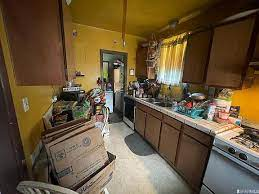

In [587]:
dill.load(open(f"{DEMO_LISTINGS_DUMPATH}/listing_images.pkd", "rb"))[0][1]

In [588]:
%%time
for address, source in dill.load(open(f"{DEMO_LISTINGS_DUMPATH}/listing_images.pkd", "rb")):
    processed_address=re.sub(" ", "-", address.split(",")[0])
    if "data:image/jpeg;base64,/9j/" in source: 
        ImgExtract.decode_base64("{}/images/{}-kitchen.jpeg"
                                 .format(DEMO_LISTINGS_DUMPATH, processed_address), 
                                 source)
    else:
        ImgExtract.decript_gstatic("{}/images/{}-kitchen.jpg"
                                   .format(DEMO_LISTINGS_DUMPATH, processed_address), 
                                   source)

full
full
full
full
full
full
full
full
full
full
full
full
full
full
full
full
CPU times: user 29.2 ms, sys: 16.7 ms, total: 45.9 ms
Wall time: 126 ms


In [610]:
Counter([address for category in LISTINGS for address in category[1]])

Counter({'8420 Birch St, Oakland, CA 94621': 1,
         '1326 Diamond St, San Francisco, CA 94131': 1,
         '815 Pacheco St, San Francisco, CA 94116': 1,
         '851 34th Ave, Oakland, CA 94601': 1,
         '6424 Foothill Blvd, Oakland, CA 94605': 1,
         '1370 Quesada Ave, San Francisco, CA 94124': 1,
         '181 Lucky St, San Francisco, CA 94110': 1,
         '353 San Jose Ave, San Francisco, CA 94110': 1,
         '1238 Sutter St #501, San Francisco, CA 94109': 1,
         '62 Natick St, San Francisco, CA 94131': 2,
         '635 Joost Ave, San Francisco, CA 94127': 1,
         '1311 Guerrero St APT 1, San Francisco, CA 94110': 1,
         '1933 B Jones St, San Francisco, CA 94133': 1,
         '708 Long Bridge St APT 110, San Francisco, CA 94158': 1,
         '101 Upper Ter, San Francisco, CA 94117': 1})

## scrape google zillow ca only 

In [75]:
def get_image_modules(in_search_term):
    MODULE_CLASS="isv-r PNCib MSM1fd BUooTd"
    browser.get(ImgExtract.search_template.format(q=in_search_term))
    sleep(7)
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight)")
    sleep(7)
    google_image_page=BeautifulSoup(browser.page_source, 'lxml')
    all_image_modules=google_image_page.body.find_all("div", {"class": MODULE_CLASS})
    return [block for block in all_image_modules]

In [79]:
def extract_address_image(in_image_module):
    TITLE_CLASS="VFACy kGQAp sMi44c lNHeqe WGvvNb"
    title = in_image_module.find_all("a", {"class":TITLE_CLASS}, title=True)[0]["title"]
    image_finding = in_image_module.find("img", src=True) 
    try:
        image_encription=image_finding["src"]
    except TypeError:
        image_encription = None
    if image_encription:
        cleaned=re.sub(r"(?i)\||zillow", "", title).strip()
        address= cleaned if ", CA" in cleaned else None
        return address, image_encription

In [81]:
LISTING_SEARCHTERMS=[
    'disrepair kitchen "CA" site:zillow.com',
    'old broken kitchen "CA" site:Redfin.com',
    'dilapidated kitchen "CA" site:zillow.com',
    'dirty kitchen "CA" site:zillow.com',
    'abandoned dirty kitchen "CA" site:zillow.com',
    'small messy kitchen "CA" site:zillow.com',

    'cheap condo kitchen "CA" site:zillow.com',
    'cheap apartment kitchen "CA" site:zillow.com',
    'motel kitchen "CA" site:zillow.com',

    'luxurious kitchen "CA" site:zillow.com',
    'expensive kitchen "CA" site:zillow.com',
    'mansion kitchen "CA" site:zillow.com']

LISTING_SEARCHTERMS_TESTING=[ 
    'motel kitchen "CA" site:zillow.com',
    'luxurious kitchen "CA" site:zillow.com'
]

In [82]:
shutil.rmtree(DEMO_LISTINGS_DUMPATH) 
os.mkdir(DEMO_LISTINGS_DUMPATH)
all_listings=[]
for index, phrase in enumerate(LISTING_SEARCHTERMS):
    print(phrase)
    image_modules=get_image_modules(phrase)
    addresses_and_images=[extract_address_image(unit) 
                          for unit 
                          in image_modules]
    addresses_and_images = [file 
                            for file 
                            in addresses_and_images if file]
    print(len(addresses_and_images))
    all_listings.extend(addresses_and_images)
len(set(all_listings))

disrepair kitchen "CA" site:zillow.com
21
old broken kitchen "CA" site:Redfin.com
20
dilapidated kitchen "CA" site:zillow.com
20
dirty kitchen "CA" site:zillow.com
26
abandoned dirty kitchen "CA" site:zillow.com
20
small messy kitchen "CA" site:zillow.com
20
cheap condo kitchen "CA" site:zillow.com
50
cheap apartment kitchen "CA" site:zillow.com
57
motel kitchen "CA" site:zillow.com
45
luxurious kitchen "CA" site:zillow.com
34
expensive kitchen "CA" site:zillow.com
23
mansion kitchen "CA" site:zillow.com
50


370

In [84]:
with open(f"{DEMO_LISTINGS_DUMPATH}/full-listings.pkd", "wb") as writefile:
    dill.dump(all_listings, writefile)
[
    os.remove(f"{DEMO_LISTINGS_DUMPATH}/{file}")
    for file in os.listdir(DEMO_LISTINGS_DUMPATH)
    if "listing-addresses-and-images" in file 
]

[]

In [85]:
try:
    os.remove(f"{DEMO_LISTINGS_DUMPATH}/address_index.pkd")
except FileNotFoundError:
    pass
try: 
    shutil.rmtree(f"{DEMO_LISTINGS_DUMPATH}/downloads")
except FileNotFoundError:
    pass
os.mkdir(f"{DEMO_LISTINGS_DUMPATH}/downloads")

with open(f"{DEMO_LISTINGS_DUMPATH}/full-listings.pkd", "rb") as readfile:
    full_listings=dill.load(readfile)
    
addr_directories=[]
for index, address_encription in enumerate(full_listings):
    address, encription=address_encription
    downloaded=(ImgExtract.decode_base64(f"{DEMO_LISTINGS_DUMPATH}/downloads/{index}.jpeg",
                                         encription) 
                if "data:image/jpeg;base64" in encription 
                else urlretrieve(encription, 
                                 filename=f"{DEMO_LISTINGS_DUMPATH}/downloads/{index}.jpg"))
    
    addr_directories.append((index, address))
    
with open(f"{DEMO_LISTINGS_DUMPATH}/downloads/address_index.pkd", "wb") as writefile:
    dill.dump(addr_directories, writefile)

In [124]:
len([file[0] for file in all_listings if not file[0]])

205

In [113]:
! cd /Users/jhshi/MyJupyterProjs/capstonedump/demo-listings 
! ls /Users/jhshi/MyJupyterProjs/capstonedump/demo-listings 
! tar -czvf addresses-and-images.tar.gz ./downloads -C .

addresses-and-images.tar.gz full-listings.pkd
downloads
tar: ./downloads: Cannot stat: No such file or directory
tar: Error exit delayed from previous errors.
